Joanna Wąsik s24273

Opis problemu
Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu. Zbiór może mieć 2 lub 3 klasy.

Następnie:

Oczyść dane i zaprezentuj rozkład klas

Zbuduj model analizy sentymenu:

z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
z wykorzystaniem sieci CNN
z podstawiemiem pre-trained word embeddingów
z fine-tuningiem modelu języka (poza podstawowym BERTem)
Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.

W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla dwnuk@pjwstk.edu.pl.

TERMIN: jak w Teamsach

In [4]:
# Import bibliotek

import pandas as pd
import numpy as np


!pip install tensorflow
!pip install -U spacy
!python -m spacy download en_core_web_md
!pip install -U Wordcloud
!pip install -U accelerate -q
!pip install -U transformers -q
!pip install -U datasets -q


import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import Activation, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time

import en_core_web_sm

import transformers

     ---------------------------------------- 42.8/42.8 MB 1.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


C:\Users\CEM\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#pacy.load('en_core_web_md')

In [6]:
# Baza danych
row_data = pd.read_csv("C://Users/CEM/Desktop/Pulpit/Udemy kursy/Data Science Analiza danych w Python i PANDAS/course-files/tripadvisor_hotel_reviews.csv")
row_data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [7]:
# Zamiana Rating na 3 klasy

row_data['Rating_class'] = row_data['Rating'].replace({5: 'Positive', 4: 'Positive', 3: 'Neutral',
                                                      2:'Negative', 1:'Negative'})
row_data

,Review,Rating,Rating_class
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


In [8]:
data = row_data.copy()
del data['Rating']

In [9]:
data.shape

(20491, 2)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        20491 non-null  object
 1   Rating_class  20491 non-null  object
dtypes: object(2)
memory usage: 320.3+ KB


In [11]:
data.groupby('Rating_class').nunique()

,Review
Rating_class,
Negative,3214
Neutral,2184
Positive,15093


<Axes: xlabel='Rating_class', ylabel='count'>

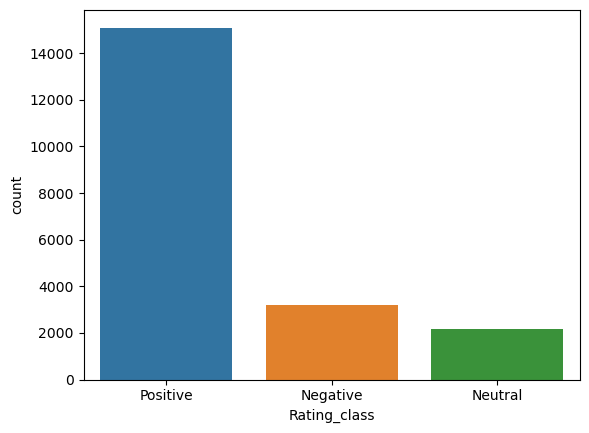

In [12]:
sns.countplot(x='Rating_class', data=data)

In [13]:
data[data['Rating_class'] == 'Positive'].sample(1)

,Review,Rating_class
18478,outstanding areas booked el gaucho site not di...,Positive


In [14]:
data[data['Rating_class'] == 'Neutral'].sample(1)

,Review,Rating_class
13569,confortable stay stay globus hotel comfortable...,Neutral


In [15]:
data[data['Rating_class'] == 'Negative'].sample(1)

,Review,Rating_class
16071,"avoid stayed hotel way europe japan, booked 3 ...",Negative


In [16]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.sample(10)

,Review,Rating_class
20111,concerns not warranted breezes 25 years old ju...,Positive
7293,"avoid like plague, heed warning stay away plac...",Negative
5011,"great place hotel run wonderful staff, locatio...",Positive
5399,excellent stylish choice stayed night business...,Positive
4104,wonderful mexico city recently stayed 4 nights...,Positive
755,just got 4 day stay definitely not recommned p...,Negative
11271,"great time, leaving read reviews got scared ho...",Positive
16720,magnificent hotel stayed hotel europa family w...,Positive
6138,20 time customer local look no ask balcony 43r...,Positive
6368,start spreading muse stayed muse weeks ago feb...,Positive


In [17]:
import spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [18]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Review'] = data['Review'].apply(remove_stopwords)
data.sample(10)

,Review,Rating_class
11472,"great hotel times square, arrived westin new y...",Positive
15301,5 star facilities/ smaller hotel feel arrived ...,Positive
15394,fabulous hotel highly recommended husband stay...,Positive
9586,"charming great value returned european cruise,...",Positive
18585,"horrible experience, positive beach area nice ...",Negative
13634,ifa incredibly false advertisement thought got...,Negative
3992,nice hotel good location family stayed hotel n...,Positive
7955,nice place great location 119usd night queen b...,Neutral
13076,bad gets night hotel- cost 1000.00- bad experi...,Negative
6484,"poor quality, stay absolutely, terrible sound ...",Negative


In [19]:
data.drop_duplicates(subset='Review', keep='first', inplace=True)

In [20]:
a=data[data['Rating_class']== 'Positive'].sample(1000)
b=data[data['Rating_class']== 'Neutral'].sample(1000)
c=data[data['Rating_class']== 'Negative'].sample(1000)

data5k = pd.concat([a,b,c])

In [21]:
zdanie = 'she likes apples'

for slowo in nlp(zdanie):
  print(slowo.lemma_)

she
like
apple


In [22]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.sample(10)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:40<00:00, 73.86it/s]


,Review,Rating_class
11466,"dirty awful sanitizing , stay hotel business ,...",Negative
15220,"avoid hotel travel kid , singapore kid well av...",Negative
5458,lcation good 1 word awful hotel terrible servi...,Negative
20009,near perfect hotel heart tokyo club deluxe roo...,Positive
13760,nice stay firenze husband stay 4 day jk place ...,Positive
203,excellent choice great choice stay close airpo...,Positive
16149,"great adain perfect stay , staff excellent rea...",Positive
2943,snafu read review go vacation kind nervous bea...,Neutral
11561,gem central berlin have day berlin wife look c...,Positive
11189,"love , time carribean , long read , great time...",Positive


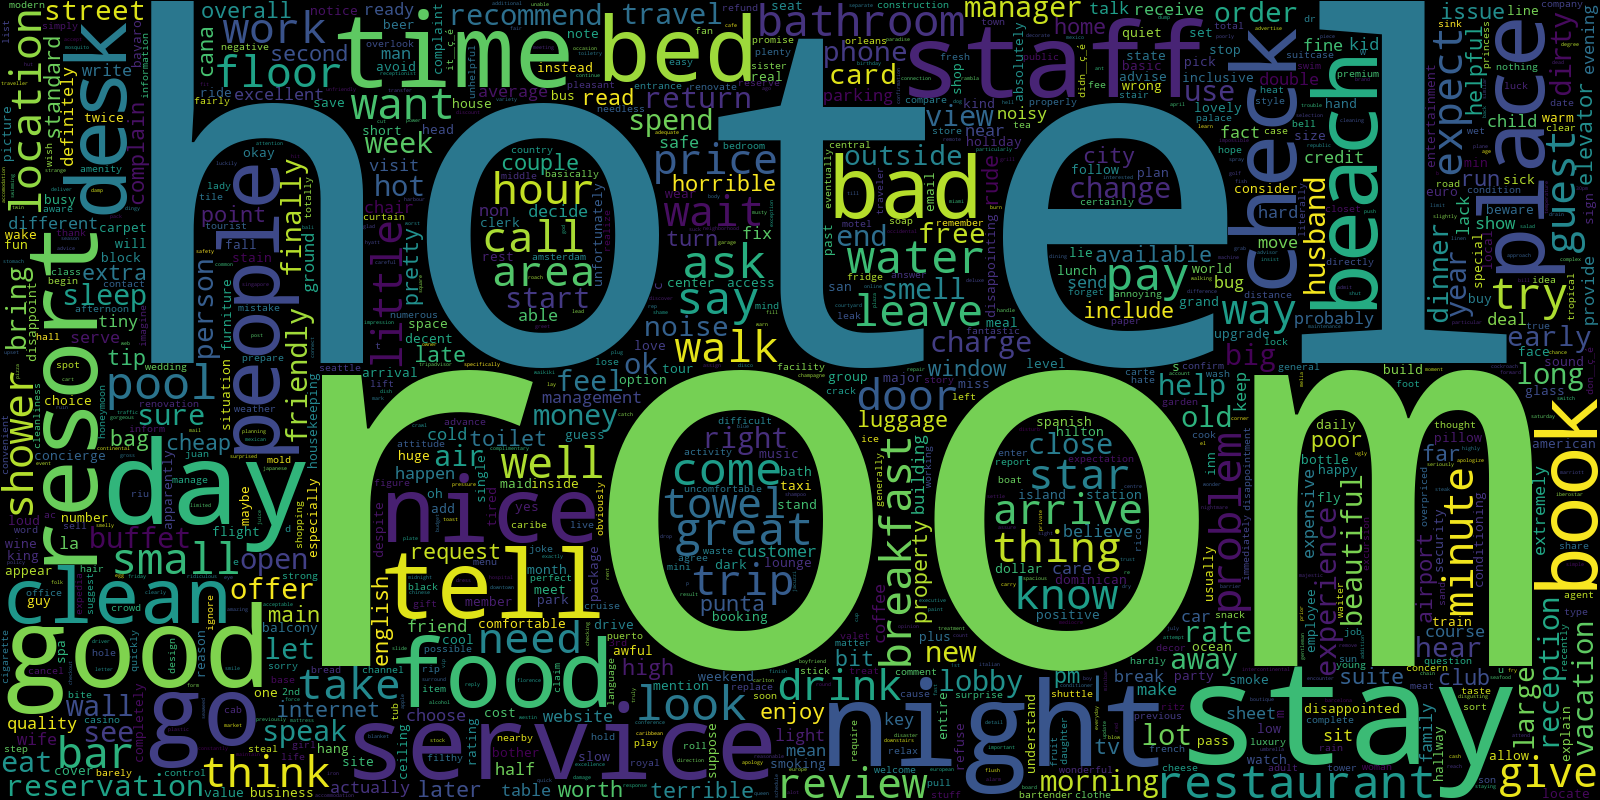

In [23]:
text_neg = ' '.join(data5k[data5k['Rating_class']== 'Negative']['Review'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

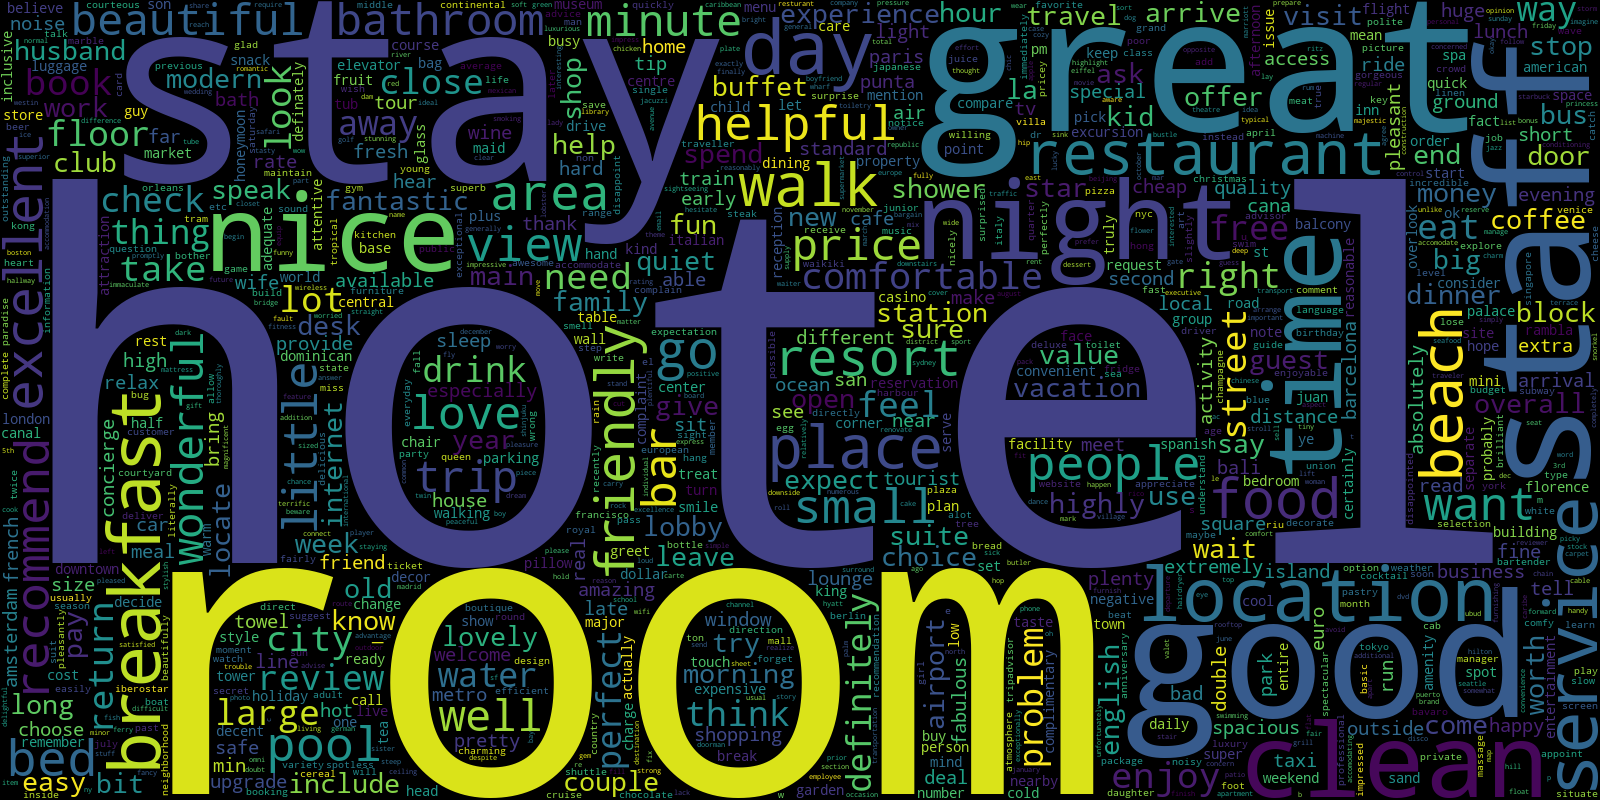

In [24]:
text_pos = ' '.join(data5k[data5k['Rating_class']== 'Positive']['Review'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [25]:
# Klasyfikacja

# Metoda train_test_split: 10% test, 90% train

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data5k.Review, data5k.Rating_class, test_size=0.1, stratify=data5k.Rating_class)

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [28]:
len(vectorizer.get_feature_names_out())

1000

In [29]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [30]:
print(X_train.shape)
print(X_test.shape)

(2700, 1000)
(300, 1000)


In [31]:
print(X_train)

  (0, 922)	0.10564635411668738
  (0, 919)	0.13642872159709404
  (0, 907)	0.15407591428963252
  (0, 903)	0.07060081799081168
  (0, 882)	0.13690176638154417
  (0, 856)	0.22551513545055324
  (0, 855)	0.09530310989326497
  (0, 854)	0.11873583383566842
  (0, 841)	0.058486485735387145
  (0, 818)	0.1618870055096425
  (0, 816)	0.12866464822342058
  (0, 756)	0.17068421211787937
  (0, 752)	0.15330654746596528
  (0, 745)	0.23953439138684396
  (0, 681)	0.09569820170555211
  (0, 667)	0.1599943942516998
  (0, 660)	0.2565805239331541
  (0, 616)	0.1035643752049605
  (0, 606)	0.1518167574695447
  (0, 586)	0.10564635411668738
  (0, 569)	0.09391003044950479
  (0, 541)	0.12475141450170403
  (0, 516)	0.11748304394115847
  (0, 514)	0.10449540831378899
  (0, 512)	0.08778452156164544
  :	:
  (2698, 228)	0.46746697050123254
  (2698, 158)	0.22099123341193885
  (2698, 130)	0.19195034701951819
  (2698, 108)	0.25940564245009295
  (2698, 107)	0.19816889001459015
  (2698, 73)	0.13829839322219684
  (2698, 70)	0.15290

In [32]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [33]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74       100
     Neutral       0.53      0.49      0.51       100
    Positive       0.63      0.69      0.66       100

    accuracy                           0.64       300
   macro avg       0.63      0.64      0.63       300
weighted avg       0.63      0.64      0.63       300



In [34]:
# Sieć CNN i LSTM

'''
z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN 
z wykorzystaniem sieci CNN
z podstawiemiem pre-trained word embeddingów z fine-tuningiem modelu języka 
(poza podstawowym BERTem) 
Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego 
pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, 
czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).
'''

!pip install -U portalocker>=2.0.0
!pip install torchtext


In [35]:
spacy.__version__ 

'3.7.2'

In [36]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [37]:
tf.__version__

'2.14.0'

In [38]:
data.head()

,Review,Rating_class
0,nice hotel expensive parking got good deal sta...,Positive
1,ok special charge diamond member hilton decide...,Negative
2,nice rooms 4* experience hotel monaco seattle ...,Neutral
3,"unique, great stay, wonderful time hotel monac...",Positive
4,"great stay great stay, went seahawk game aweso...",Positive


In [39]:
data['Rating_class'] = data['Rating_class'].replace({'Positive':3, 'Neutral':2,
                                                      'Negative': 1})
data

,Review,Rating_class
0,nice hotel expensive parking got good deal sta...,3
1,ok special charge diamond member hilton decide...,1
2,nice rooms 4* experience hotel monaco seattle ...,2
3,"unique, great stay, wonderful time hotel monac...",3
4,"great stay great stay, went seahawk game aweso...",3
...,...,...
20486,"best kept secret 3rd time staying charm, 5-sta...",3
20487,great location price view hotel great quick pl...,3
20488,"ok looks nice modern outside, desk staff parti...",1
20489,hotel theft ruined vacation hotel opened sept ...,1


In [40]:
data['targets'] = data['Rating_class'].astype("category").cat.codes

In [41]:
# liczba klas

K = data['targets'].max()+1
K

3

In [42]:
data_train, data_test = train_test_split(data,test_size = 0.3)

In [43]:
data_train.head()

,Review,Rating_class,targets
18927,fantastic family get-away stayed ocean blue re...,3,2
8439,drawer hotel recently wife young daughter went...,3,2
3008,great choice husband visited hotel anniversary...,1,0
2580,"great resort family, 2 adults 2 children ages ...",3,2
13640,ideal spot friendly hosts hotel le relais du m...,3,2


In [44]:
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_train['Review'])
sequeces_train = tokenizer.texts_to_sequences(data_train['Review'])
sequeces_test = tokenizer.texts_to_sequences(data_test['Review'])

In [45]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Znaleziono %s uniktowych tokenów.'%V)

Znaleziono 43654 uniktowych tokenów.


In [46]:
df_train = pad_sequences(sequeces_train)
print('Kształt tensora treningowego:', df_train.shape)

Kształt tensora treningowego: (14343, 1414)


In [47]:
T = df_train.shape[1]

In [48]:
df_test = pad_sequences(sequeces_test, maxlen = T)
print('Kształt tensora treningowego:', df_test.shape)

Kształt tensora treningowego: (6148, 1414)


In [49]:
# Model CNN

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [50]:
D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [51]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 5,
    batch_size = 512,
    validation_data = (df_test, data_test['targets'])
)

Training model ...
Epoch 1/5
29/29 [==============================] - 10s 292ms/step - loss: 1.0167 - accuracy: 0.5792 - val_loss: 0.9027 - val_accuracy: 0.7363
Epoch 2/5
29/29 [==============================] - 8s 289ms/step - loss: 0.8224 - accuracy: 0.7367 - val_loss: 0.7511 - val_accuracy: 0.7363
Epoch 3/5
29/29 [==============================] - 9s 298ms/step - loss: 0.7325 - accuracy: 0.7367 - val_loss: 0.7134 - val_accuracy: 0.7363
Epoch 4/5
29/29 [==============================] - 9s 295ms/step - loss: 0.6907 - accuracy: 0.7367 - val_loss: 0.6613 - val_accuracy: 0.7363
Epoch 5/5
29/29 [==============================] - 9s 305ms/step - loss: 0.6282 - accuracy: 0.7447 - val_loss: 0.5900 - val_accuracy: 0.7786


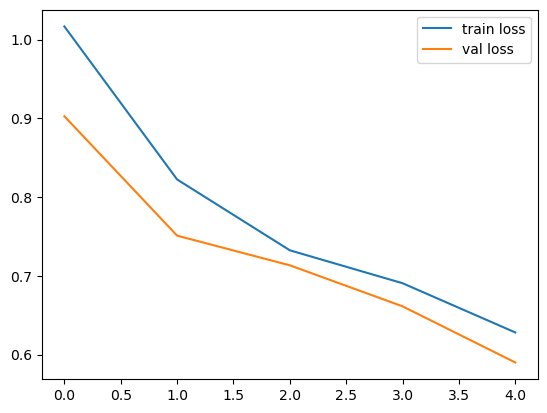

In [52]:
import matplotlib.pyplot as plt

# wykres loss

plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend();

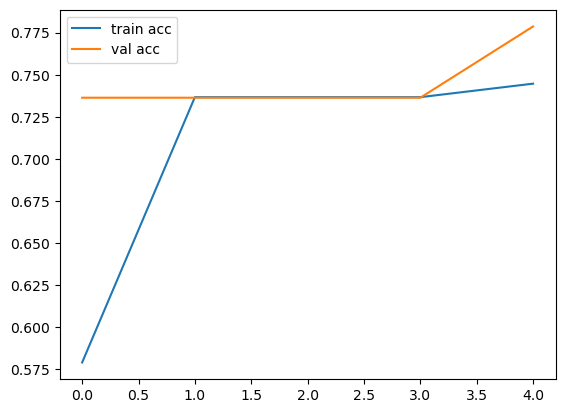

In [53]:
# awykres ccuracy

plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend();

In [54]:
# Model LSTM


D = 20

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation = 'relu')(x)
x = LSTM(32, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [55]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [56]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 5,
    batch_size = 512,
    validation_data = (df_test, data_test['targets'])
)

Training model ...
Epoch 1/5
29/29 [==============================] - 232s 8s/step - loss: 0.9534 - accuracy: 0.7171 - val_loss: 0.7599 - val_accuracy: 0.7363
Epoch 2/5
29/29 [==============================] - 291s 10s/step - loss: 0.7548 - accuracy: 0.7367 - val_loss: 0.7490 - val_accuracy: 0.7363
Epoch 3/5
29/29 [==============================] - 403s 14s/step - loss: 0.7424 - accuracy: 0.7367 - val_loss: 0.7107 - val_accuracy: 0.7363
Epoch 4/5
29/29 [==============================] - 482s 17s/step - loss: 0.6593 - accuracy: 0.7367 - val_loss: 0.5999 - val_accuracy: 0.7363
Epoch 5/5
29/29 [==============================] - 487s 17s/step - loss: 0.5581 - accuracy: 0.7696 - val_loss: 0.5277 - val_accuracy: 0.8271


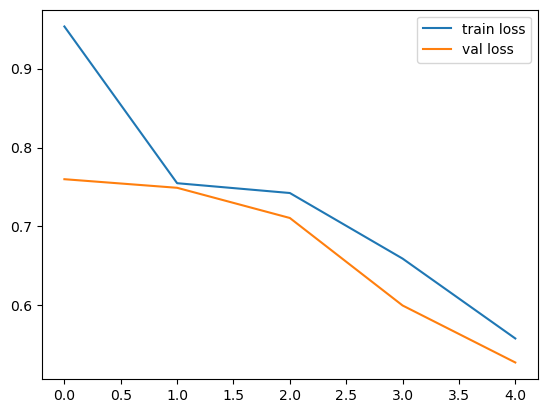

In [57]:
import matplotlib.pyplot as plt

# wykres straty

plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend();


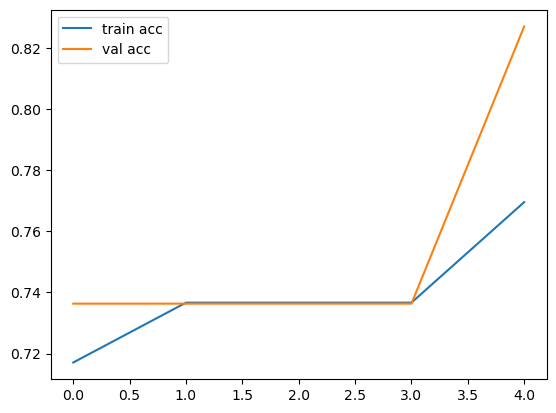

In [58]:

# accuracy

plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend();

In [59]:
criterion = nn.BCEWithLogitsLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

AttributeError: 'Functional' object has no attribute 'to'

In [ ]:
transformers.__version__

In [ ]:
data.rename(columns={'targets':'label'}, inplace=True)
data.rename(columns={'Review':'text'}, inplace=True)
del data['Rating_class']
data.sample(3)

In [ ]:
from datasets import Dataset

dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(0.1)

In [ ]:
model_checkpoint = 'microsoft/deberta-base'
batch_size = 128

In [ ]:
# Budujemy sieć LSTM
import torch 
import torch.nn as nn

In [ ]:
from transformers import AutoTokenizer
max_length = 512

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = max_length
                                         , max_model_input_sizes = max_length)

In [ ]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

In [ ]:
train_ds

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis', # model = model?
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

In [ ]:
trainer.train()

In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/demo')

In [ ]:
trainer.model

In [ ]:
import torch

text = data['text'].loc[12219]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
if predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

In [ ]:
data['text'].loc[12219]